# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

2024-02-07 22:18:18.824026: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 22:18:18.824118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 22:18:19.020041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Prepare Data

In [2]:
# Load datasets
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# Extract labels and features
y = train_df['label']
X = train_df.drop('label', axis=1)
test = test_df.values
# One Hot Encode: Could also use F.one_hot from pytorch.Functional 
y = tf.keras.utils.to_categorical(y, num_classes=10)

# Normalize pixel values to [0, 1]
X = X / 255.0
test = test / 255.0

# Convrt to pytorch tensors for torch model compatibility
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# For Convollutional neural networks
# X = X.view(-1, 1, 28, 28)
# test = test.view(-1, 1, 28, 28)


# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## Define a neural network in pytorch

In [3]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fcl1 = nn.Linear(28*28, 100)
        self.relu = nn.ReLU()
        self.fcl2 = nn.Linear(100, 50)
        self.fcl3 = nn.Linear(50, 10)

    def forward(self, x):
        # x = x.view(-1,28**2) to get the length to 28*28
        x = self.relu(self.fcl1(x))
        x = self.relu(self.fcl2(x))
        x = self.fcl3(x)

        return x.squeeze()
    

In [4]:
L = nn.CrossEntropyLoss()
f =  NeuralNet()

L(f(X_train), y_train)

tensor(2.3085, grad_fn=<DivBackward1>)

In [5]:
train_dataset = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_dataset, batch_size=5, shuffle=True)

for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([5, 784])
torch.Size([5, 10])


In [6]:
def train_model(dl, f, n_epochs=20):
    # Optimization
    opt = optim.SGD(f.parameters(), lr=0.01)
    L = nn.CrossEntropyLoss()

    # Train model
    losses = []
    epochs = []
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}')
        N = len(dl)
        for i, (x, y) in enumerate(dl):
            # Update the weights of the network
            opt.zero_grad() 
            loss_value = L(f(x), y) 
            loss_value.backward() 
            opt.step() 
            # Store training data
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)

In [7]:
epoch_data, loss_data = train_model(train_dl, f)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Cross Entropy (per batch)')

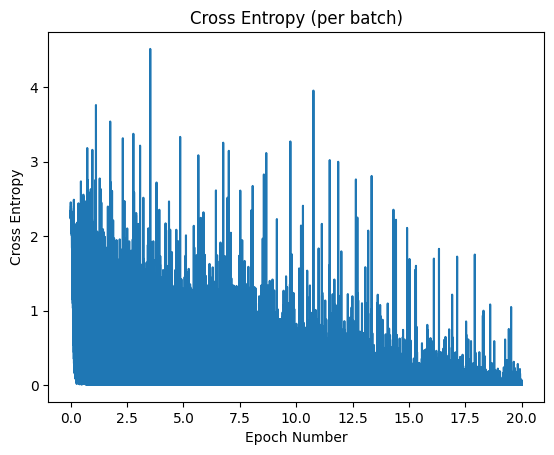

In [8]:
plt.plot(epoch_data, loss_data)
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (per batch)')

In [9]:
epoch_data_avgd = epoch_data.reshape(20,-1).mean(axis=1)
loss_data_avgd = loss_data.reshape(20,-1).mean(axis=1)

Text(0.5, 1.0, 'Cross Entropy (avgd per epoch)')

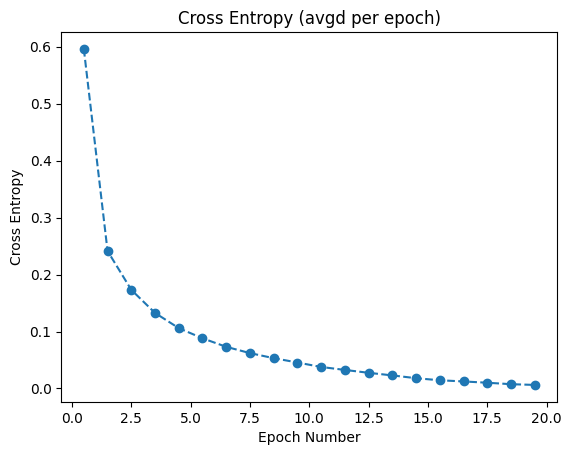

In [10]:
plt.plot(epoch_data_avgd, loss_data_avgd, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (avgd per epoch)')

Predicted value:2


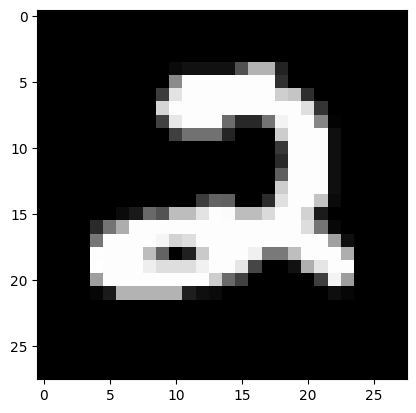

In [11]:
sample = test[0]
sample = torch.tensor(sample, dtype=torch.float32)
sample = sample.unsqueeze(0)
with torch.no_grad():  # No need to compute gradients during inference
    y_hat = f(sample)

# Get the predicted class label
predicted_label = torch.argmax(y_hat)
print(f'Predicted value:{predicted_label}')

# Show the sample using imshow
plt.imshow(sample.view(28, 28), cmap='gray')  # Reshape the sample back to 28x28 and plot
plt.show()



In [12]:
# The test needs to be in the following shape (batch, 28*28)

with torch.no_grad():
    test_tensor = torch.tensor(test, dtype=torch.float32)
    # test_tensor = test_tensor.view(-1, 784)  # Reshape to ensure correct input shape
    pred = f(test_tensor)
    pred_labels = torch.argmax(pred, dim=1)
print(pred_labels)

tensor([2, 0, 9,  ..., 3, 9, 2])


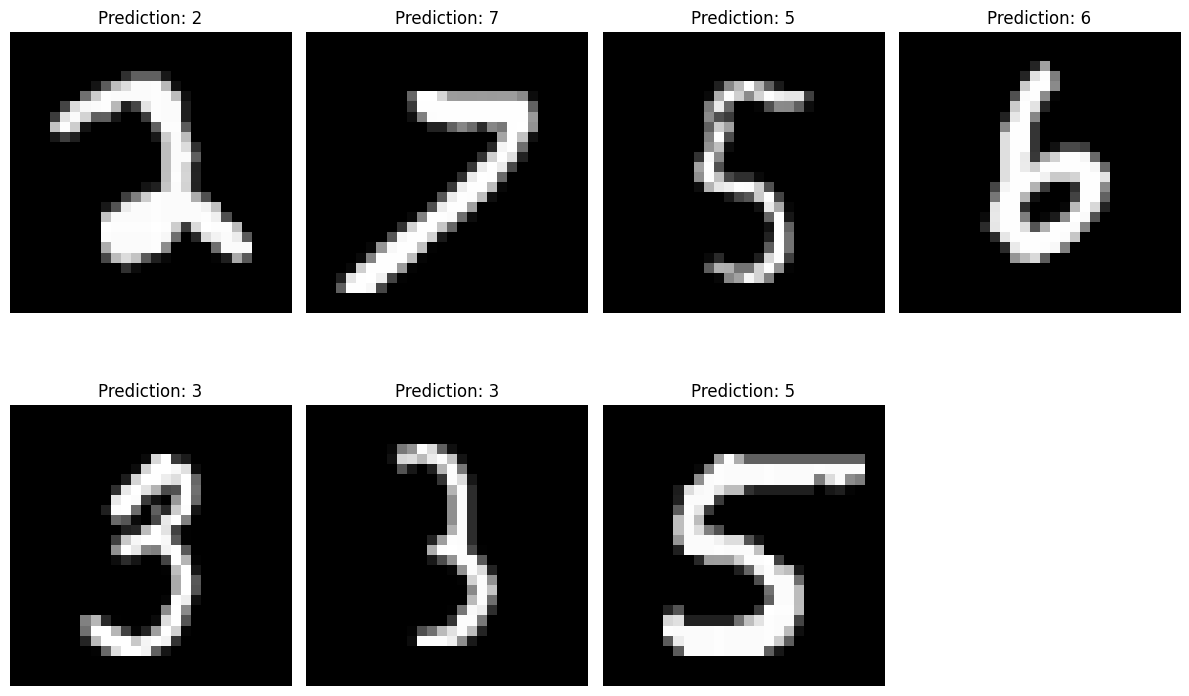

In [13]:
import random

# Choose 7 random indices from the test data
random_indices = random.sample(range(len(test)), 7)

# Plot the images along with their predictions
plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices, 1):
    plt.subplot(2, 4, i)
    plt.imshow(test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Prediction: {pred_labels[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
submission_df = pd.DataFrame({
    'ImageId': range(1, len(test)+1),
    'Label': pred_labels
})

In [15]:
submission_df.to_csv('torch.csv', index=False)

I0000 00:00:1707344502.242437     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


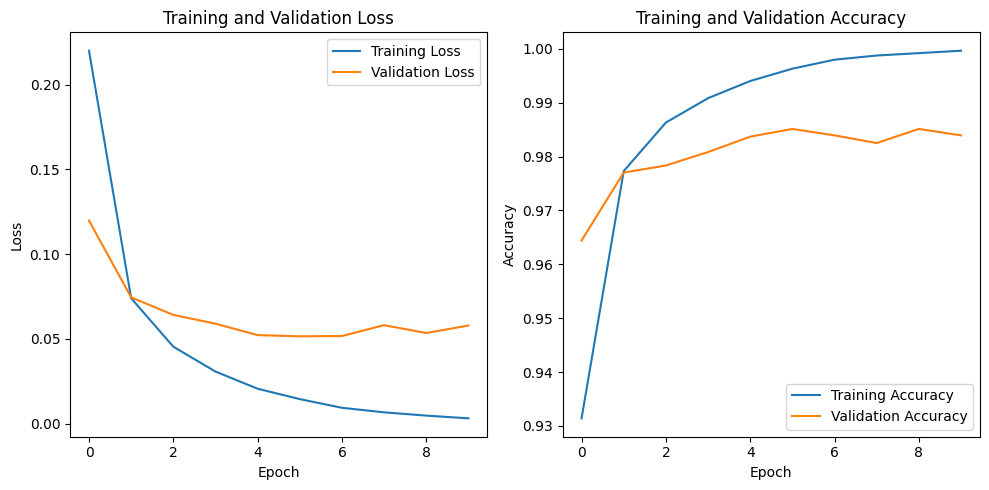

Validation Loss: 0.0579080656170845


In [16]:
# Convert to numpy for compatibillity for keras
X_train2 = X_train.numpy()
X_val2 = X_val.numpy()
y_train2 = y_train.numpy()
y_val2 = y_val.numpy()

# Reshap (Batch, height, witdth, channel)
X_train2 = X_train2.reshape(X_train2.shape[0], 28, 28, 1)
X_val2 = X_val2.reshape(X_val2.shape[0], 28, 28, 1)

test2 = test.reshape(test.shape[0], 28, 28, 1)

def define_model():
   model = tf.keras.models.Sequential()
   model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
   model.add(tf.keras.layers.MaxPooling2D((2, 2)))
   model.add(tf.keras.layers.Flatten())
   model.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
   model.add(tf.keras.layers.Dense(10, activation='softmax'))
   # compile model
   opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
   model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
   return model


# Step 1: Define and compile the model
model = define_model()
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Step 2: Train the model on the training data
history = model.fit(X_train2, y_train2, epochs=10, batch_size=32, validation_data=(X_val2, y_val2), verbose=0)

# Step 3: Visualize training history
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Step 4: Evaluate the model on the validation data
loss, accuracy = model.evaluate(X_val2, y_val2, verbose=0)

# Step 5: Print the loss
print('Validation Loss:', loss)



875/875 [==============================] - 1s 2ms/step


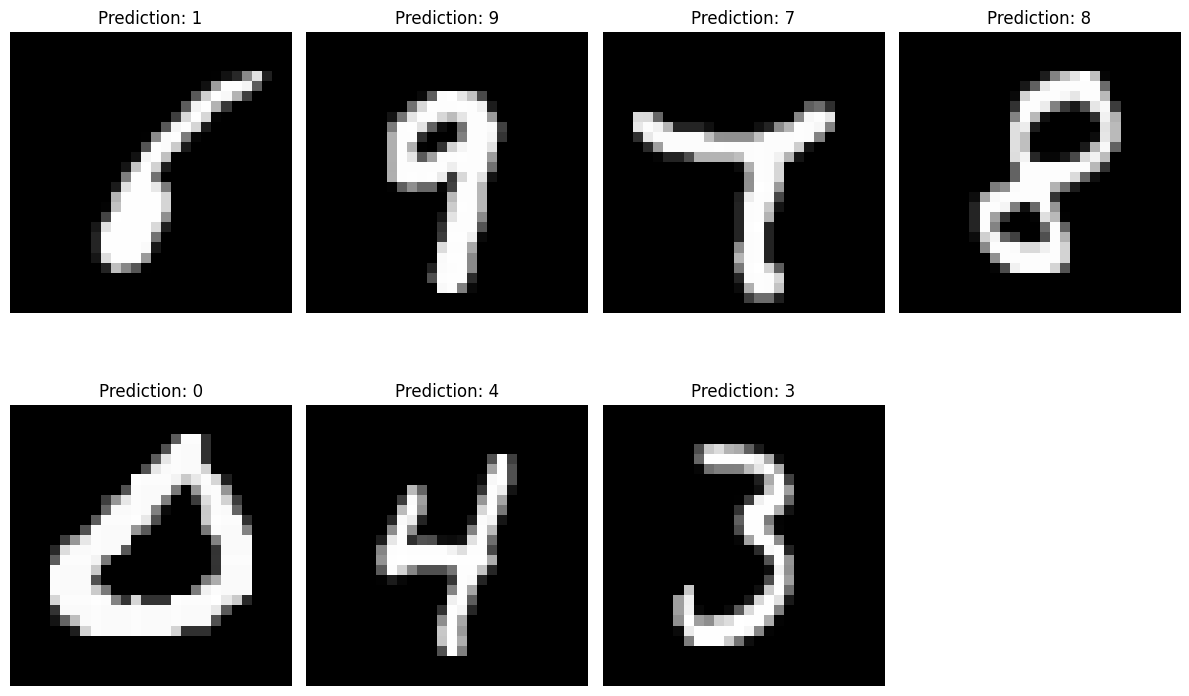

In [17]:
# Step 1: Make predictions on the test data
predictions2 = model.predict(test2)
pred_labels2 = np.argmax(predictions2, axis=1)

# Step 2: Choose random indices from the test data
random_indices = np.random.choice(len(test), 7, replace=False)

# Step 3: Plot the images along with their predictions
plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices, 1):
    plt.subplot(2, 4, i)
    plt.imshow(test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Prediction: {pred_labels[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Step 4: Optionally, create a DataFrame for submission
submission_df = pd.DataFrame({
    'ImageId': range(1, len(test)+1),
    'Label': pred_labels
})

In [18]:
# Step 4: Optionally, create a DataFrame for submission
submission_df2 = pd.DataFrame({
    'ImageId': range(1, len(test)+1),
    'Label': pred_labels2
})

In [19]:
submission_df.to_csv('keras.csv', index=False)